In [3]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import os
import random

tf.compat.v1.disable_eager_execution()
tf.random.set_random_seed(1234)

In [17]:
df = pd.read_csv(r'C:\Users\HP\Downloads\vn100_prices.csv', parse_dates=['TradingDate'])
df.set_index('TradingDate', inplace=True)
df.head()

,AAA,ACB,AGG,ANV,ASM,BCG,BCM,BID,BMP,BVH,...,VIB,VIC,VIX,VJC,VND,VNM,VPB,VPI,VRE,VSH
TradingDate,,,,,,,,,,,,,,,,,,,,,
2021-07-15,14092,18383,35518,24477,8324,8745,43506,29988,42473,45594,...,24463,90668,8505,114800,14386,74177,21456,28536,28000,17741
2021-07-16,13915,18860,35448,24341,8600,8782,41439,29847,42699,46045,...,24436,94046,8428,115400,14281,74786,21624,28495,27700,17656
2021-07-19,13076,18046,35238,22706,8084,8224,39131,27846,41721,43337,...,22747,91468,7856,114000,13199,74002,20115,28131,26800,17107
2021-07-20,13650,19029,35308,23978,8324,8447,38554,28794,42473,45052,...,22883,91557,7837,114500,14456,74786,20316,27928,26700,17741
2021-07-21,13650,18973,35518,23251,8496,8373,37689,28583,42172,44691,...,22393,92446,7780,114000,14456,74264,20216,28049,27400,17234


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2021-07-15 to 2024-06-07
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   AAA     701 non-null    int64
 1   ACB     701 non-null    int64
 2   AGG     701 non-null    int64
 3   ANV     701 non-null    int64
 4   ASM     701 non-null    int64
 5   BCG     701 non-null    int64
 6   BCM     701 non-null    int64
 7   BID     701 non-null    int64
 8   BMP     701 non-null    int64
 9   BVH     701 non-null    int64
 10  BWE     701 non-null    int64
 11  CII     701 non-null    int64
 12  CMG     701 non-null    int64
 13  CRE     701 non-null    int64
 14  CTD     701 non-null    int64
 15  CTG     701 non-null    int64
 16  CTR     701 non-null    int64
 17  DBC     701 non-null    int64
 18  DCM     701 non-null    int64
 19  DGC     701 non-null    int64
 20  DGW     701 non-null    int64
 21  DHC     701 non-null    int64
 22  DIG     701 non-null    int64


In [19]:
df.isnull().sum()

AAA    0
ACB    0
AGG    0
ANV    0
ASM    0
      ..
VNM    0
VPB    0
VPI    0
VRE    0
VSH    0
Length: 100, dtype: int64

In [21]:
random_column = random.choice(df.columns)
df = df[[random_column]]
df

,VIB
TradingDate,
2021-07-15,24463
2021-07-16,24436
2021-07-19,22747
2021-07-20,22883
2021-07-21,22393
...,...
2024-06-03,22300
2024-06-04,22400
2024-06-05,22400


In [22]:
minmax = MinMaxScaler().fit(df.astype('float32'))
df_log = minmax.transform(df.astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.876236
1,0.874258
2,0.750495
3,0.760460
4,0.724555


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [23]:
test_size = 30
simulation_size = 5

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((701, 1), (671, 1), (30, 1))

In [24]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict): 
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [25]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 5
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [26]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [27]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


train loop: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s, acc=91.7, cost=0.0235]


simulation 2


train loop: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s, acc=91.8, cost=0.0232]


simulation 3


train loop: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s, acc=91.7, cost=0.0234]


simulation 4


train loop: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s, acc=91.7, cost=0.0236]


simulation 5


train loop: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s, acc=91.6, cost=0.0251]


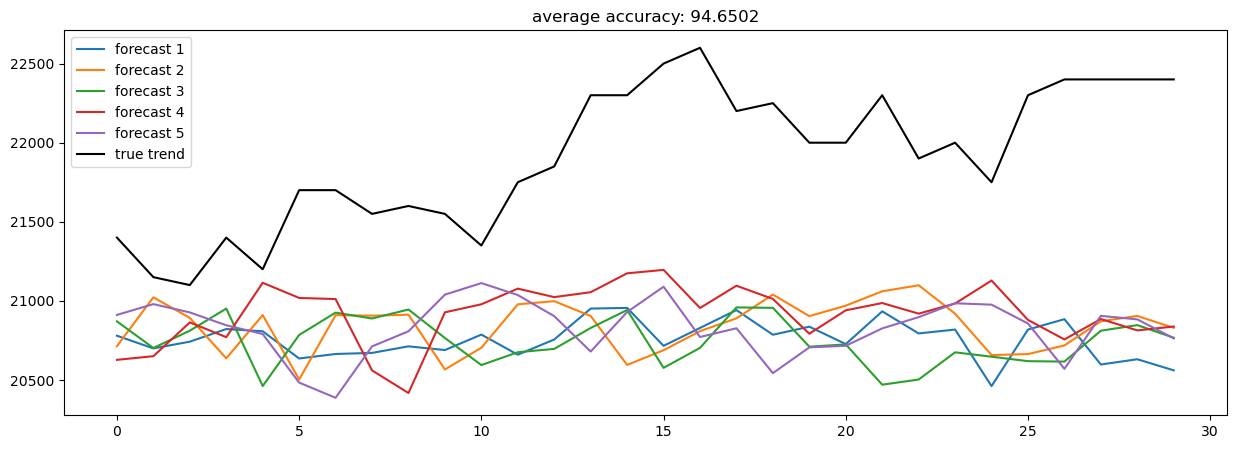

In [29]:
accuracies = [calculate_accuracy(df.iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df.iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()